In [1]:
from __future__ import print_function
import numpy as np
from scipy.io import loadmat
import os
import glob
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

print("import done")

import done


Create Datasets by randomly mixing 10min segments of preictal and interictal data.

In [14]:
#convert .mat data into ndarray and compress it usingle pickle
def mat_to_numpy(files):
    print('Converting files ' + files[0] + ' to ' + files[-1])
    nrfiles = len(files)
    placeholder_data = np.ndarray(shape=(nrfiles, 400*10*60, 16), dtype=np.float32)
    for idx, fl in enumerate(files):
        #open mat file
        mat = loadmat(fl)
        #convert from ndarray object to ndarray
        names = mat['dataStruct'].dtype.names
        ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
        #detect if columns out of order
        if not all(x<y for x, y in zip(ndata['channelIndices'][0], ndata['channelIndices'][0][1:])):
            print('WARNING: Columns out of order in file' + fl)
        # Normalize data: axis = 0 is to normalize along columns, vertical lines.
        #todo: Is it ok to normalize or not?
        placeholder_data[idx, :, :] = (ndata['data'] - np.mean(ndata['data'], axis=0))/np.std(ndata['data'], axis=0)
    
    return placeholder_data

nrOfFiles = 40

def create_dataset(folder, name_pickle):
    #get files
    files_preictal = glob.glob(folder + "/*1.mat")
    files_interictal = glob.glob(folder + "/*0.mat")
    #randomize read files
    np.random.shuffle(files_preictal)
    np.random.shuffle(files_interictal)
    #read files into ndarrays
    data_preictal = mat_to_numpy(files_preictal[:nrOfFiles])
    labels_preictal = np.ones(data_preictal.shape[0], dtype=np.int32)
    data_interictal = mat_to_numpy(files_interictal[:nrOfFiles])
    labels_interictal = np.zeros(data_interictal.shape[0], dtype=np.int32)
    #concatenate preictal and interictal data
    print('Merging and shuffling data..')
    data_merge = np.concatenate((data_preictal, data_interictal), axis=0)
    labels_merge = np.concatenate((labels_preictal, labels_interictal), axis=0)
    #shuffle data and labels mantaining relation between them
    shuffle_idx = np.random.permutation(data_merge.shape[0])
    data_merge = data_merge[shuffle_idx,:,:]
    labels_merge = labels_merge[shuffle_idx]
    #budle data and labels in dictionary
    save = {'data': data_merge, 'labels': labels_merge}
    try:
        with open(name_pickle, 'wb') as f:
            print('Pickling to ' + name_pickle)
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to' + name_pickle + ' :', e)
    
create_dataset('./train_1', 'trainsh1_norm.pickle')

print('dataset done')

Converting files ./train_1/1_118_1.mat to ./train_1/1_117_1.mat


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in divide


Converting files ./train_1/1_1042_0.mat to ./train_1/1_605_0.mat
Merging and shuffling data..
Pickling to trainsh1_norm.pickle
dataset done


Load pickled dataset into memory.

In [12]:
name_pickle = 'trainsh1_norm.pickle'

with open(name_pickle, 'rb') as f:
    print('Unpickling ' + name_pickle)
    load = pickle.load(f)
    dataset = load['data']
    labels = load['labels']
    del load
    print('Data loaded: shape', dataset.shape)

Unpickling trainsh1_norm.pickle
Data loaded: shape (80, 240000, 16)


Plot some data to have an idea of how it looks like

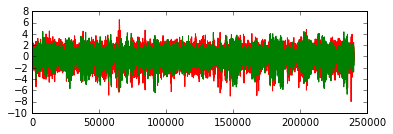

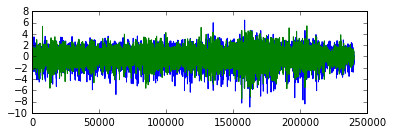

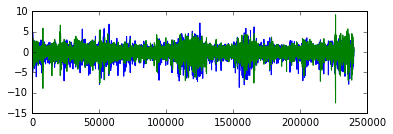

In [13]:
plt.subplot(211)
plt.plot(dataset[0,:,0], 'r')
plt.plot(dataset[0,:,8], 'g')

plt.figure(2)
plt.subplot(211)
plt.plot(dataset[23,:,0])
plt.plot(dataset[23,:,8])

plt.figure(3)
plt.subplot(211)
plt.plot(dataset[57,:,9])
plt.plot(dataset[57,:,5])

EEGNET implementation

Ideas
  - Condition classification based on sensor?
  
Part of https://arxiv.org/pdf/1609.03499.pdf that most concerns classification:
"As a last experiment we looked at speech recognition with WaveNets on the TIMIT (Garofolo et al., 1993) dataset. For this task we added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames spanning 10 milliseconds (160 x downsampling). The pooling layer was followed by a few non-causal convolutions. We trained WaveNet with two loss terms, one to predict the next sample and one to classify the frame, the model generalized better than with a single loss and achieved 18.8 PER on the test set, which is to our knowledge the best score obtained from a model trained directly on raw audio on TIMIT."

In [2]:
class eegNet(object):
    '''eegNet is based on WaveNet for generative audio.
    '''

    def __init__(self,
                 batch_size,
                 dilations,
                 filter_width,
                 input_channels,
                 residual_channels,
                 dilation_channels,
                 skip_channels,
                 fast_generation=False):
        '''Initializes the WaveNet model.
        Args:
            batch_size: How many files are supplied per batch.
            dilations: A list with the dilation factor for each layer.
            filter_width: Samples in each convolution after dilating.
            input_channels: How many filters to learn for the input.
            residual_channels: How many filters to learn for the residual.
            dilation_channels: How many filters to learn for the dilated convolution.
            skip_channels: How many filters to learn for the softmax output.
            fast_generation: Whether to use the fast generation architecture.
        '''
        self.batch_size = batch_size
        self.dilations = dilations
        self.filter_width = filter_width
        self.input_channels = input_channels
        self.residual_channels = residual_channels
        self.dilation_channels = dilation_channels
        self.skip_channels = skip_channels
        self.fast_generation = fast_generation

        if self.fast_generation:
            raise NotImplementedError('Fast generation not yet implemented.')
    
    
    def _create_weights_variable(name, shape):
        initializer = tf.contrib.layers.xavier_initializer_conv2d()
        return tf.Variable(initializer(shape=shape), name=name)


    def _create_bias_variable(name, shape):
        return tf.Variable(tf.zeros(shape=shape), name=name)
    
    
    def _create_dilation_layer(self, batch_data, layer_index, dilation):
        '''Creates a single causal dilated convolution layer.
        The layer contains a gated filter that connects to dense output
        and to a skip connection:
               |-> [gate]   -|        |-> 1x1 conv -> skip output
               |             |-> (*) -| 
        input -|-> [filter] -|        |-> 1x1 conv -|
               |                                    |-> (+) -> dense output
               |------------------------------------|
        Where `[gate]` and `[filter]` are causal convolutions with a
        non-linear activation at the output.
        '''
        #Filter part
        weights_filter = create_weights_variable("weights_filter", [1, self.filter_width, 
                                                                    self.residual_channels, 
                                                                    self.dilation_channels])
        biases_filter = create_bias_variable("biases_filter", [self.dilation_channels])
        conv_filter = tf.nn.atrous_conv2d(batch_data, weights_filter, dilation, padding='SAME', name='filter')
        conv_filter = tf.add(conv_filter, biases_filter)
        conv_filter = tf.tanh(conv_filter) 
        
        #Gated part
        weights_gate = create_weights_variable("weights_gate", [1, self.filter_width, 
                                                                self.residual_channels, 
                                                                self.dilation_channels])
        biases_gate = create_bias_variable("biases_gate", [self.dilation_channels])
        conv_gate = tf.nn.atrous_conv2d(batch_data, weights_gate, dilation, padding='SAME', name='gate')
        conv_gate = tf.add(conv_gate, biases_gate)
        conv_gate = tf.sigmoid(conv_gate)
        
        # filter + gated output
        out = tf.mul(conv_filter, conv_gate)

        # The 1x1 conv to produce the dense contribution.
        weights_dense = create_weights_variable("weights_dense", [1, 1, 
                                                                  self.dilation_channels, 
                                                                  self.residual_channels])
        biases_dense = create_bias_variable("biases_dense", [in_channels])
        conv_dense = tf.nn.conv2d(out, weights_dense, [1, 1, 1, 1], padding="SAME", name="dense")
        conv_dense = tf.add(conv_dense, biases_dense)
        # output to next layer
        conv_dense = tf.add(conv_dense, batch_data)

        # The 1x1 conv to produce the skip contribution.
        weights_skip = create_weights_variable("weights_skip", [1, 1, 
                                                                self.dilation_channels, 
                                                                self.skip_channels])
        biases_skip = create_bias_variable("biases_skip", [skip_channels])
        conv_skip = tf.nn.conv2d(out, weights_skip, [1, 1, 1, 1], padding="SAME", name="skip")
        # output to final decision softmax layer
        conv_skip = tf.add(conv_skip, biases_skip)

        layer = 'layer{}'.format(layer_index)
        tf.histogram_summary(layer + '_weights_filter', weights_filter)
        tf.histogram_summary(layer + '_weights_gate', weights_gate)
        tf.histogram_summary(layer + '_weights_dense', weights_dense)
        tf.histogram_summary(layer + '_weights_skip', weights_skip)
        tf.histogram_summary(layer + '_biases_filter', biases_filter)
        tf.histogram_summary(layer + '_biases_gate', biases_gate)
        tf.histogram_summary(layer + '_biases_dense', biases_dense)
        tf.histogram_summary(layer + '_biases_skip', biases_skip)

        return conv_skip, conv_dense
     
        
    def _create_network(self, batch_data):
        outputs = []
        current_layer = batch_data

        # Process input with causal convolution layer
        with tf.name_scope('causal_layer'):
            weights_causal = create_weights_variable("weights_causal", 
                                                     [1, self.filter_width, 
                                                      self.input_channels,
                                                      self.residual_channels])
            current_layer = tf.nn.conv2d(current_layer, weights_causal, [1, 1, 1, 1], padding='SAME')

        # Add all defined dilation layers.
        with tf.name_scope('dilated_stack'):
            for layer_index, dilation in enumerate(self.dilations):
                with tf.name_scope('layer{}'.format(layer_index)):
                    output, current_layer = self._create_dilation_layer(
                        current_layer, layer_index, dilation)
                    outputs.append(output)

        with tf.name_scope('output'):
            # (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv -> Softmax -> Output
            weights_out1 = create_variable("weights_out1", [1, 1, 
                                                            self.skip_channels, 
                                                            self.skip_channels])
            biases_out1 = create_bias_variable("biases_out1", [self.skip_channels])
            weights_out2 = create_variable("weights_out2", [1, 1, 
                                                            self.skip_channels, 1])
            biases_out2 = create_bias_variable("biases_out2", [1])
            
            tf.histogram_summary('weights_out1', weights_out1)
            tf.histogram_summary('weights_out2', weights_out2)
            tf.histogram_summary('biases_out1', biases_out1)
            tf.histogram_summary('biases_out2', biases_out2)

            # Skip connections from each layer are all added here
            out = tf.nn.relu(sum(outputs))
            out = tf.nn.conv2d(out, weights_out1, [1, 1, 1, 1], padding="SAME")
            out = tf.add(out, biases_out1)
            out = tf.nn.relu(out)
            out = tf.nn.conv2d(out, weights_out2, [1, 1, 1, 1], padding="SAME")
            out = tf.add(out, biases_out2)
    
        return out

    def loss(self, batch_data, batch_labels, name='eegnet'):
        '''Creates a eegNet network and returns the loss.
        The variables are all scoped to the given name.
        '''
        with tf.name_scope(name):
            logits = self._create_network(batch_data)

            with tf.name_scope('loss'):
                loss = tf.nn.softmax_cross_entropy_with_logits(logits, batch_labels)
                
                # Optimizer.
                  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

                tf.scalar_summary('loss', reduced_loss)

        return loss

net = eegNet(
        batch_size=1,
        dilations=[1, 2, 4, 8, 16, 32, 64, 128, 256, 1, 2, 4, 8, 16, 32, 64, 128, 256],
        filter_width=2,
        input_channels=16,
        residual_channels=32,
        dilation_channels=16,
        skip_channels=256,
        fast_generation=False)

print('done')

done
